# Predição de Resultados no Futebol Usando a Distribuição de Poisson

Este notebook demonstra como prever resultados de partidas de futebol usando o modelo de Distribuição de Poisson. Utilizaremos dados da Série A do Campeonato Brasileiro para calcular a capacidade ofensiva e defensiva das equipes e, em seguida, aplicar a Distribuição de Poisson para estimar a probabilidade de diferentes placares finais. Este método é simples, mas eficiente para introdução no mundo das predições esportivas.

Antes de tudo, é necessário esclarecer uma coisa: Existem diversos modelos de previsão de gols com distribuição de poisson, mas nós vamos utilizar o mais simples, que utiliza apenas o histórico de partidas das duas equipes. Modelos mais complexos podem levar em conta outras variáveis, como qualidade do gramado, histórico de disputas entre as equipes, entre outros.


## Fluminense x Internacional

Para começar, precisamos decidir que jogos queremos prever: vamos tentar prever o número de gols de um Fluminense x Internacional no Maracanã em 2023, utilizando os dados dos dois times da temporada 2022 do Brasileirão.

### 1. Importação das Bibliotecas Necessárias

Primeiramente, importamos as bibliotecas Python que serão utilizadas ao longo do notebook. São elas:
- `pandas`: Para manipulação e análise de dados, especialmente DataFrames (tabelas).
- `numpy`: Para operações numéricas e arrays.
- `matplotlib.pyplot`: Para a criação de visualizações estáticas e interativas.
- `seaborn`: Para visualizações estatísticas mais atraentes e informativas, construído sobre `matplotlib`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Carregamento dos Dados

Existem diferentes maneiras de carregar os dados:
1. CSV com os dados
2. Webscraping de um site

Para esse curso, escolhemos carregar os dados dos resultados da Série A do Campeonato Brasileiro de 2022 diretamente de uma tabela HTML do site 'fbref.com'.
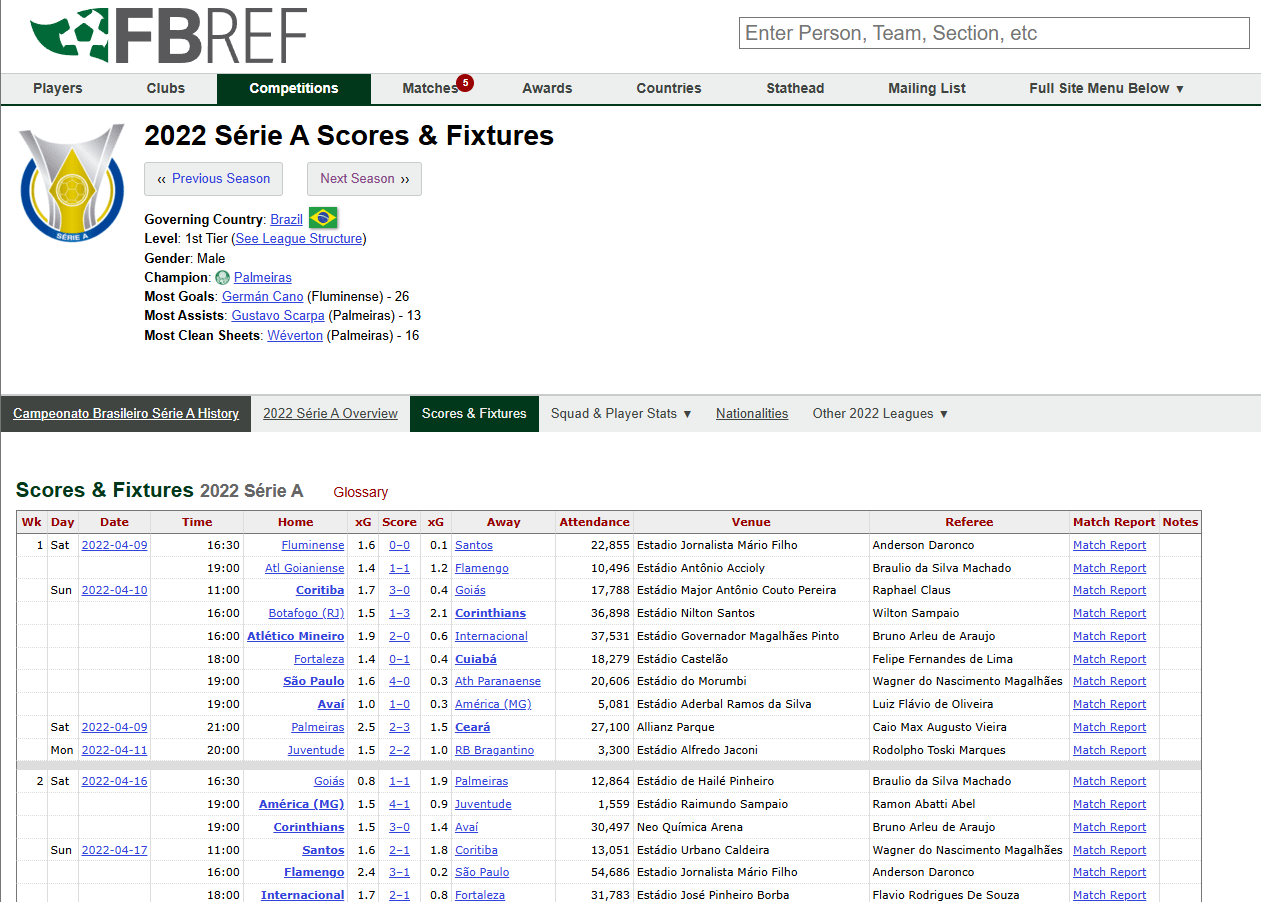
Para pegar dados de um site, existem algumas maneiras. O `pd.read_html` é uma função poderosa do pandas que lê tabelas HTML diretamente de uma URL.

In [2]:
df = pd.read_html("https://fbref.com/pt/comps/24/2022/cronograma/2022-Serie-A-Resultados-e-Calendarios")[0]
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 10)
df

HTTPError: HTTP Error 403: Forbidden

Como vocês podem ver, alguns sites proíbem o acesso de scripts, para evitar essa captura de dados. Para contornar isso, utilizaremos a biblioteca Selenium.

- `selenium`: Uma biblioteca para automação de navegadores web, permitindo simular a interação de um usuário com uma página, como clicar em botões e extrair conteúdo gerado por JavaScript.

### Entendendo o Código Selenium

A célula a seguir utiliza a biblioteca `Selenium` para contornar a restrição de acesso a dados (`HTTP Error 403: Forbidden`) que encontramos. Em vez de simplesmente tentar baixar a página, o Selenium simula um navegador real (neste caso, o Google Chrome) abrindo a página, esperando o conteúdo carregar e, em seguida, extraindo as informações.

Vamos detalhar o que acontece:

1.  **Importações**: Carregamos as bibliotecas necessárias: `pandas` para manipulação de dados, e componentes do `selenium` e `webdriver_manager` para controlar o navegador.
2.  **Definição da URL**: A variável `url` armazena o endereço da página que queremos acessar.
5.  **Inicialização do Driver**: Basta utilizar `webdriver.Chrome(...)` para iniciar o navegador.
6.  **Acesso à URL**: `driver.get(url)` instrui o navegador a carregar a página desejada.
7.  **Espera (`time.sleep`)**: Damos um tempo para a página carregar completamente, incluindo qualquer conteúdo dinâmico que possa ser gerado por JavaScript. Isso é crucial para garantir que todo o HTML esteja disponível para ser extraído.
8.  **Leitura do Título**: O título da página (`driver.title`) é impresso para confirmar que a página correta foi carregada.
9. **Extração da Tabela**: `pd.read_html(driver.page_source)` usa o Pandas para ler todas as tabelas HTML presentes no código-fonte *completo* da página, como seria feito caso não houvesse o erro HTTP 403.
10. **Fechamento do Navegador**: `driver.quit()` encerra a sessão do navegador, liberando os recursos.



In [3]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

# 1. A URL
url = "https://fbref.com/en/comps/24/2022/schedule/2022-Serie-A-Scores-and-Fixtures"



try:
  print("Iniciando o GOOGLE CHROME")

  # 2. Usar o webdriver-manager.
  driver = webdriver.Chrome()

  # 3. Abrir a URL
  driver.get(url)
  print(f"Navegador aberto na URL. Esperando 8 segundos...")
  time.sleep(8)


  # 4. Imprimir o título da página
  print("--- Diagnóstico ---")
  print(f"Título da Página: {driver.title}")

  print("-------------------")

  # 5. Tentar ler a tabela
  print("Tentando ler tabelas com Pandas...")
  lista_de_dataframes = pd.read_html(driver.page_source)

  if not lista_de_dataframes:
    print("Erro: Pandas não encontrou NENHUMA tag <table> no HTML.")
  else:
    print(f"Sucesso! Pandas encontrou {len(lista_de_dataframes)} tabela(s).")
    df = lista_de_dataframes[0]
    print(df.head())

  driver.quit()

except Exception as e:
   print(f"Ocorreu um erro geral: {e}")

Iniciando o GOOGLE CHROME
Navegador aberto na URL. Esperando 8 segundos...
--- Diagnóstico ---
Título da Página: 2022 Série A Scores & Fixtures | FBref.com
-------------------
Tentando ler tabelas com Pandas...
Sucesso! Pandas encontrou 1 tabela(s).
  Wk  Day        Date   Time              Home   xG Score xG.1           Away  \
0  1  Sat  2022-04-09  16:30        Fluminense  1.6   0–0  0.1         Santos   
1  1  Sat  2022-04-09  19:00    Atl Goianiense  1.4   1–1  1.2       Flamengo   
2  1  Sun  2022-04-10  11:00          Coritiba  1.7   3–0  0.4          Goiás   
3  1  Sun  2022-04-10  16:00     Botafogo (RJ)  1.5   1–3  2.1    Corinthians   
4  1  Sun  2022-04-10  16:00  Atlético Mineiro  1.9   2–0  0.6  Internacional   

  Attendance                                Venue                   Referee  \
0      22855       Estadio Jornalista Mário Filho          Anderson Daronco   
1      10496              Estádio Antônio Accioly  Braulio da Silva Machado   
2      17788  Estádio Majo

C:\Users\extre\AppData\Local\Temp\ipykernel_13016\2660875752.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  lista_de_dataframes = pd.read_html(driver.page_source)


In [4]:
#df.to_csv('jogos_brasileirao22.csv', index=False)

In [5]:
#df = pd.read_csv('jogos_brasileirao22.csv')
#df

In [6]:
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 10)
df

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,1,Sat,2022-04-09,16:30,Fluminense,1.6,0–0,0.1,Santos,22855,Estadio Jornalista Mário Filho,Anderson Daronco,Match Report,NaN
1,1,Sat,2022-04-09,19:00,Atl Goianiense,1.4,1–1,1.2,Flamengo,10496,Estádio Antônio Accioly,Braulio da Silva Machado,Match Report,NaN
2,1,Sun,2022-04-10,11:00,Coritiba,1.7,3–0,0.4,Goiás,17788,Estádio Major Antônio Couto Pereira,Raphael Claus,Match Report,NaN
3,1,Sun,2022-04-10,16:00,Botafogo (RJ),1.5,1–3,2.1,Corinthians,36898,Estádio Nilton Santos,Wilton Sampaio,Match Report,NaN
4,1,Sun,2022-04-10,16:00,Atlético Mineiro,1.9,2–0,0.6,Internacional,37531,Estádio Governador Magalhães Pinto,Bruno Arleu de Araujo,Match Report,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,38,Sun,2022-11-13,16:00,América (MG),2.1,1–1,0.5,Atl Goianiense,NaN,Estádio Raimundo Sampaio,Leandro Pedro Vuaden,Match Report,NaN
429,38,Sun,2022-11-13,16:00,RB Bragantino,0.9,0–1,0.6,Fluminense,NaN,Estádio Nabi Abi Chedid,Bruno Arleu de Araujo,Match Report,NaN
430,38,Sun,2022-11-13,16:00,Santos,1.0,0–2,1.4,Fortaleza,NaN,Estádio Urbano Caldeira,Wagner do Nascimento Magalhães,Match Report,NaN
431,38,Sun,2022-11-13,16:00,Ceará,2.3,4–1,0.7,Juventude,NaN,Estádio Castelão,Paulo Henrique Schleinch Vollkopf,Match Report,NaN


Podemos notar que a tabela tem algumas linhas erradas. No bloco anterior vimos que o dataframe tem 433 linhas, enquanto o campeonato brasileiro possui 380 jogos por temporada. Além de algumas linhas nulas, o FBREF possui outras colunas com falha:

In [7]:
linhas_erradas = df[df['Wk'] == 'Wk']
linhas_erradas

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
35,Wk,Day,Date,Time,Home,xG,Score,xG,Away,Attendance,Venue,Referee,Match Report,Notes
71,Wk,Day,Date,Time,Home,xG,Score,xG,Away,Attendance,Venue,Referee,Match Report,Notes
107,Wk,Day,Date,Time,Home,xG,Score,xG,Away,Attendance,Venue,Referee,Match Report,Notes
143,Wk,Day,Date,Time,Home,xG,Score,xG,Away,Attendance,Venue,Referee,Match Report,Notes
179,Wk,Day,Date,Time,Home,xG,Score,xG,Away,Attendance,Venue,Referee,Match Report,Notes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,Wk,Day,Date,Time,Home,xG,Score,xG,Away,Attendance,Venue,Referee,Match Report,Notes
287,Wk,Day,Date,Time,Home,xG,Score,xG,Away,Attendance,Venue,Referee,Match Report,Notes
323,Wk,Day,Date,Time,Home,xG,Score,xG,Away,Attendance,Venue,Referee,Match Report,Notes
359,Wk,Day,Date,Time,Home,xG,Score,xG,Away,Attendance,Venue,Referee,Match Report,Notes


### 3. Seleção e Limpeza Inicial dos Dados Relevantes

Filtramos o DataFrame original para manter apenas as colunas essenciais para nossa análise: 'Sem' (Semana), 'Data', 'Em casa', 'Resultado' e 'Visitante'. Em seguida, removemos quaisquer linhas que contenham valores ausentes (`NaN`) e as com dados "errados", onde Wk se repete nas linhas. Fazemos isso em *todas* as colunas selecionadas, garantindo que estamos trabalhando apenas com dados completos e válidos para os resultados das partidas.

In [8]:
resultados = df[['Wk', 'Date', 'Home', 'Score', 'Away']]
resultados.columns = ['Sem', 'Data', 'Mandante', 'Resultado', 'Visitante']
resultados = resultados.dropna(how='all')
resultados = resultados[resultados['Sem'] != 'Wk']
resultados

,Sem,Data,Mandante,Resultado,Visitante
0,1,2022-04-09,Fluminense,0–0,Santos
1,1,2022-04-09,Atl Goianiense,1–1,Flamengo
2,1,2022-04-10,Coritiba,3–0,Goiás
3,1,2022-04-10,Botafogo (RJ),1–3,Corinthians
4,1,2022-04-10,Atlético Mineiro,2–0,Internacional
...,...,...,...,...,...
428,38,2022-11-13,América (MG),1–1,Atl Goianiense
429,38,2022-11-13,RB Bragantino,0–1,Fluminense
430,38,2022-11-13,Santos,0–2,Fortaleza
431,38,2022-11-13,Ceará,4–1,Juventude


### 4. Extração dos Gols de Mandante e Visitante

A coluna 'Resultado' está no formato 'GolsMandante–GolsVisitante'. Precisamos separar esses valores em duas novas colunas numéricas: 'GolsMandante' e 'GolsVisitante'. Utilizamos o método `.str.split

In [9]:
placar = resultados.loc[:,"Resultado"].str.split("–", n = 1, expand = True)
resultados.loc[:,"GolsMandante"] = placar.loc[:,0]
resultados.loc[:,"GolsVisitante"] = placar.loc[:,1] #GolsVisi
resultados = resultados.drop(columns=["Resultado"])
resultados['GolsMandante'] = resultados['GolsMandante'].astype(int)
resultados['GolsVisitante'] = resultados['GolsVisitante'].astype(int)
resultados

,Sem,Data,Mandante,Visitante,GolsMandante,GolsVisitante
0,1,2022-04-09,Fluminense,Santos,0,0
1,1,2022-04-09,Atl Goianiense,Flamengo,1,1
2,1,2022-04-10,Coritiba,Goiás,3,0
3,1,2022-04-10,Botafogo (RJ),Corinthians,1,3
4,1,2022-04-10,Atlético Mineiro,Internacional,2,0
...,...,...,...,...,...,...
428,38,2022-11-13,América (MG),Atl Goianiense,1,1
429,38,2022-11-13,RB Bragantino,Fluminense,0,1
430,38,2022-11-13,Santos,Fortaleza,0,2
431,38,2022-11-13,Ceará,Juventude,4,1


### 5. Cálculo das Médias de Gols (Capacidade Ofensiva)

Para o modelo de Poisson, nós podemos buscar diferentes métricas para calcular o Lambda. No nosso caso, escolhemos usar as médias de gols marcados e sofridos. Aqui, calculamos as médias de gols marcados em casa e fora de casa, que representam a capacidade ofensiva geral do campeonato.

- **Média de Gols Marcados pelo Mandante (`MediaGolsMarMandante`)**: Representa a média de gols que as equipes marcam quando jogam em seu próprio estádio.
- **Média de Gols Marcados pelo Visitante (`MediaGolsMarVisitante`)**: Representa a média de gols que as equipes marcam quando jogam fora de casa.

In [10]:
#Capacidade Ofensiva
#Gols Marcados como Mandante
MediaGolsMarMandante = resultados['GolsMandante'].sum() / 380
print(MediaGolsMarMandante)

#Gols Marcados como Visitante
MediaGolsMarVisitante = resultados['GolsVisitante'].sum() / 380
print(MediaGolsMarVisitante)

1.4052631578947368
0.9763157894736842


In [11]:
print("Gols como Mandante", resultados['GolsMandante'].sum())

Gols como Mandante 534


In [12]:
print("Gols como Visitante", resultados['GolsVisitante'].sum())

Gols como Visitante 371


### 6. Cálculo das Médias de Gols Sofridos (Capacidade Defensiva)

De forma análoga, calculamos as médias de gols sofridos em casa e fora, que representam a capacidade defensiva geral do campeonato.

- **Média de Gols Sofridos como Mandante (`MediaGolsSofMandante`)**: Representa a média de gols que as equipes sofrem quando jogam em seu próprio estádio.
- **Média de Gols Sofridos como Visitante (`MediaGolsSofVisitante`)**: Representa a média de gols que as equipes sofrem quando jogam fora de casa.

In [13]:
#Capacidade Defensiva
#Gols Sofridos como Mandante
MediaGolsSofMandante = resultados['GolsVisitante'].sum() / 380
print(MediaGolsSofMandante)

#Gols Sofridos como Visitante
MediaGolsSofVisitante = resultados['GolsMandante'].sum() / 380
print(MediaGolsSofVisitante)

0.9763157894736842
1.4052631578947368


### 7. Previsão de Gols para a Equipe Mandante (Fluminense)

Agora, aplicamos os conceitos de capacidade ofensiva e defensiva para prever a quantidade de gols que o Fluminense (jogando como mandante) pode marcar contra o Internacional (jogando como visitante). A lógica é a seguinte:

1.  **Capacidade Ofensiva do Fluminense**: Calculamos a média de gols que o Fluminense marcou jogando em casa e a comparamos com a média geral de gols marcados por mandantes no campeonato.
2.  **Capacidade Defensiva do Internacional**: Calculamos a média de gols que o Internacional sofreu jogando como visitante e a comparamos com a média geral de gols sofridos por visitantes no campeonato.
3.  **Gols Prováveis do Fluminense**: O número provável de gols que o Fluminense marcará é dado pela multiplicação de sua capacidade ofensiva, a capacidade defensiva do Internacional e a média geral de gols marcados em casa.

In [14]:
#Prever gols do Flu x Inter

#Prever os gols do Flu
#Capacidade ofensiva flu
Fluminense = resultados.loc[resultados['Mandante'] == 'Fluminense']
GolsMarMandanteFlu = Fluminense['GolsMandante'].sum()
print(GolsMarMandanteFlu)
MediaGolsMarMandanteFlu = GolsMarMandanteFlu/19 #19 é o número de rodadas como mandante
print("Media Gols Marcados como Mandante pelo Fluminense: ", MediaGolsMarMandanteFlu)
CapacidadeOfensivaFlu = MediaGolsMarMandanteFlu/MediaGolsMarMandante
print("Capacidade Ofensiva do Fluminense: ",CapacidadeOfensivaFlu)

#Capacidade Defensiva Inter
Internacional = resultados.loc[resultados['Visitante'] == 'Internacional']
GolsSofVisitanteInter = Internacional['GolsMandante'].sum()
print(GolsSofVisitanteInter)
MediaGolsSofVisitanteInter = GolsSofVisitanteInter/19
print("Media Gols Sofridos como Visitante pelo Internacional:", MediaGolsSofVisitanteInter)
CapacidadeDefensivaInter = MediaGolsSofVisitanteInter/MediaGolsSofVisitante
print("Capacidade Defensiva do Internacional: ",CapacidadeDefensivaInter)

#numero provavel de gols que o fluminense pode marcar
ProvavelGolsFlu = CapacidadeOfensivaFlu * CapacidadeDefensivaInter * MediaGolsMarMandante
print("Número Provável de Gols do Flu no Confronto: ",ProvavelGolsFlu)

39
Media Gols Marcados como Mandante pelo Fluminense:  2.0526315789473686
Capacidade Ofensiva do Fluminense:  1.460674157303371
17
Media Gols Sofridos como Visitante pelo Internacional: 0.8947368421052632
Capacidade Defensiva do Internacional:  0.6367041198501873
Número Provável de Gols do Flu no Confronto:  1.3069189828503847


### 8. Previsão de Gols para a Equipe Visitante (Internacional)

Seguimos a mesma lógica do passo anterior para prever a quantidade de gols que o Internacional (jogando como visitante) pode marcar contra o Fluminense (jogando como mandante):

1.  **Capacidade Ofensiva do Internacional**: Calculamos a média de gols que o Internacional marcou jogando como visitante e a comparamos com a média geral de gols marcados por visitantes no campeonato.
2.  **Capacidade Defensiva do Fluminense**: Calculamos a média de gols que o Fluminense sofreu jogando como mandante e a comparamos com a média geral de gols sofridos por mandantes no campeonato.
3.  **Gols Prováveis do Internacional**: O número provável de gols que o Internacional marcará é dado pela multiplicação de sua capacidade ofensiva, a capacidade defensiva do Fluminense e a média geral de gols marcados fora.

In [15]:
#Prever os Gols do Inter
#Capacidade ofensiva Inter
GolsMarVisitanteInter = Internacional['GolsVisitante'].sum()
print(GolsMarVisitanteInter)
MediaGolsMarVisitanteInter = GolsMarVisitanteInter/19
CapacidadeOfensivaInter = MediaGolsMarVisitanteInter/MediaGolsMarVisitante
print("Capacidade Ofensiva do Internacional: ",CapacidadeOfensivaInter)

#Capacidade Defensiva Flu
GolsSofMandanteFlu = Fluminense['GolsVisitante'].sum()
print(GolsSofMandanteFlu)
MediaGolsSofMandanteFlu = GolsSofMandanteFlu/19
CapacidadeDefensivaFlu = MediaGolsSofMandanteFlu/MediaGolsSofMandante
print("Capacidade Defensiva do Fluminense: ",CapacidadeDefensivaFlu)

#numero provavel de gols que o Internacional pode marcar
ProvavelGolsInter = CapacidadeOfensivaInter * CapacidadeDefensivaFlu * MediaGolsMarVisitante
print("Número Provável de Gols do Inter no Confronto: ",ProvavelGolsInter)

18
Capacidade Ofensiva do Internacional:  0.9703504043126684
20
Capacidade Defensiva do Fluminense:  1.0781671159029649
Número Provável de Gols do Inter no Confronto:  1.0214214782238613


### 9. Calculando Probabilidades de Gols Individuais (Distribuição de Poisson)

A Distribuição de Poisson é ideal para modelar a ocorrência de eventos (como gols) em um intervalo fixo (como uma partida de futebol) quando esses eventos acontecem com uma taxa média conhecida e independentemente uns dos outros. Aqui, usamos a função `poisson.pmf` (probability mass function) para calcular a probabilidade de cada time marcar 0, 1, 2, 3, 4 ou 5 gols, dado o seu número provável de gols calculado anteriormente (ProvavelGolsFlu e ProvavelGolsInter).

In [16]:
from scipy.stats import poisson
print(poisson.pmf(0,ProvavelGolsFlu))
print(poisson.pmf(1,ProvavelGolsFlu))
print(poisson.pmf(2,ProvavelGolsFlu))


0.27065265857790183
0.3537210972543839
0.23114240831821067


In [17]:
print(poisson.pmf(0,ProvavelGolsInter))
print(poisson.pmf(1,ProvavelGolsInter))
print(poisson.pmf(2,ProvavelGolsInter))



0.36008272645455935
0.3677962307380943
0.18783748484283433


### 10. Calculando Probabilidades de Gols para um Intervalo (0 a `max_goals`)

Expandimos o cálculo da Distribuição de Poisson para um intervalo de gols de 0 até `max_goals` (neste caso, 5). Isso nos dá um array com as probabilidades de cada time marcar 0, 1, 2, 3, 4 ou 5 gols. Esses arrays, `PoissonFlu` e `PoissonFla`, serão a base para construir a matriz de placares.

In [18]:
max_goals = 5 #5 ou mais é um menos o array somado: (1 - np.sum(PoissonFlu))
goal_range = np.arange(0, max_goals + 1)


PoissonFlu = poisson.pmf(goal_range, ProvavelGolsFlu)  # Flu
PoissonInter = poisson.pmf(goal_range, ProvavelGolsInter)  # Inter
print(PoissonFlu)
print(PoissonInter)

[0.27065266 0.3537211  0.23114241 0.1006948  0.03289999 0.00859952]
[0.36008273 0.36779623 0.18783748 0.06395375 0.01633093 0.00333615]


### 11. Construção da Matriz de Probabilidades e Visualização (Heatmap)

Com as probabilidades de gols individuais de cada time, construímos uma matriz de probabilidades (`score_matrix`) onde cada célula representa a probabilidade de um placar específico (e.g., Fluminense 2 x 1 Internacional). Isso é feito usando o produto externo (`np.outer`) das probabilidades de Poisson de cada time.

Um `heatmap` do Seaborn é então utilizado para visualizar essa matriz, tornando as probabilidades de cada placar facilmente compreensíveis. Cores mais quentes indicam maiores probabilidades.

Finalmente, calculamos as probabilidades de vitória para cada time e a probabilidade de empate, somando as áreas relevantes da matriz:

Flu Win Probability: 42.86%
Inter Win Probability: 29.05%
Draw Probability: 27.80%


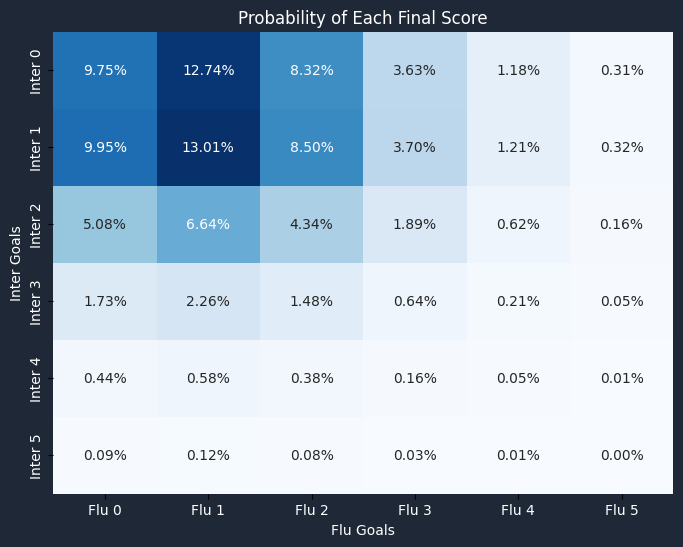

In [19]:
# Matriz de probabilidades
score_matrix = np.outer(PoissonInter, PoissonFlu)

df = pd.DataFrame(score_matrix, index=[f"Inter {i}" for i in goal_range],
                   columns=[f"Flu {i}" for i in goal_range])


# Visualização do heatmap
plt.figure(figsize=(8, 6), facecolor="#1E2836")  # Define o fundo da figura
ax = sns.heatmap(df, annot=True, fmt=".2%", cmap="Blues", cbar=False)
ax.set_facecolor("#1E2836")  # Define o fundo do gráfico
plt.title("Probability of Each Final Score", color="white")  # Ajusta cor do título
plt.xlabel("Flu Goals", color="white")  # Ajusta cor do eixo X
plt.ylabel("Inter Goals", color="white")  # Ajusta cor do eixo Y
plt.xticks(color="white")  # Ajusta cor dos rótulos do eixo X
plt.yticks(color="white")  # Ajusta cor dos rótulos do eixo Y

# Computar probabilidades
Flu_win_prob = np.sum(np.triu(score_matrix, k=1))  # Upper triangle
Inter_win_prob = np.sum(np.tril(score_matrix, k=-1))  # Lower triangle
draw_prob = np.sum(np.diag(score_matrix))  # Diagonal

print(f"Flu Win Probability: {Flu_win_prob:.2%}")
print(f"Inter Win Probability: {Inter_win_prob:.2%}")
print(f"Draw Probability: {draw_prob:.2%}")

plt.show()


### Interpretação das Probabilidades no Heatmap

No heatmap gerado, cada célula representa a probabilidade de um placar específico, com os gols do Internacional no eixo Y e os gols do Fluminense no eixo X.

Para calcular as probabilidades de vitória e empate, somamos as probabilidades das células relevantes na matriz:

*   **Probabilidade de Empate**: É a soma das probabilidades nas células da **linha diagonal principal** (onde o número de gols de ambos os times é igual, por exemplo, 0x0, 1x1, 2x2, etc.).

*   **Probabilidade de Vitória do Fluminense**: É a soma das probabilidades nas células do **triângulo superior** da matriz (onde o número de gols do Fluminense é maior que o número de gols do Internacional).

*   **Probabilidade de Vitória do Internacional**: É a soma das probabilidades nas células do **triângulo inferior** da matriz (onde o número de gols do Internacional é maior que o número de gols do Fluminense).

*   **Probabilidade de Vitória do Fluminense: 42.86%**
*   **Probabilidade de Vitória do Internacional: 29.05%**
*   **Probabilidade de Empate: 27.80%**


### E qual foi o resultado real dessa partida?

A partida onde o Fluminense foi mandante no Brasileirão 2023 terminou em 2x0 pro Flu.

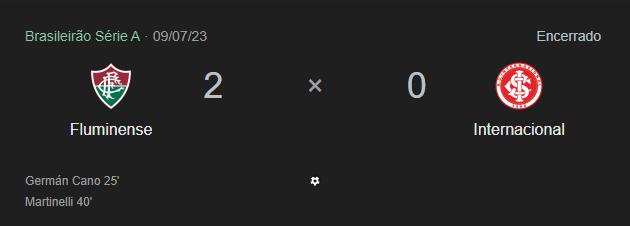

### Lembrando...

Sempre é possível encorpar o modelo. Como foi dito anteriormente, o modelo é simples, utilizando apenas jogos do Brasileirão anterior. Uma forma possível para melhorar, seria utilizar dados de outros campeonatos brasileiros, até o jogo anterior ao que você quer prever, considerando uma suavização exponencial para resultados mais antigos para levar em consideração coisas como mudança de elenco ou de técnico.

## Considerando que amanhã teremos um FlaFlu (com mando do Flu), o que vocês acham de tentar prever o resultado dessa partida?

In [20]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import time

# 1. A URL
url = "https://fbref.com/en/comps/24/2024/schedule/2024-Serie-A-Scores-and-Fixtures"


try:
  print("Iniciando o GOOGLE CHROME...")

  # 2. Usar o webdriver-manager.
  driver = webdriver.Chrome()

  # 3. Abrir a URL
  driver.get(url)
  print(f"Navegador aberto na URL. Esperando 8 segundos...")
  time.sleep(8)


  # 4. Imprimir o título da página
  print("--- Diagnóstico ---")
  print(f"Título da Página: {driver.title}")

  print("-------------------")

  # 5. Tentar ler a tabela
  print("Tentando ler tabelas com Pandas...")
  lista_de_dataframes = pd.read_html(driver.page_source)

  if not lista_de_dataframes:
    print("Erro: Pandas não encontrou NENHUMA tag <table> no HTML.")
  else:
    print(f"Sucesso! Pandas encontrou {len(lista_de_dataframes)} tabela(s).")
    df2 = lista_de_dataframes[0]
    print(df2.head())

  driver.quit()

except Exception as e:
   print(f"Ocorreu um erro geral: {e}")

Iniciando o GOOGLE CHROME...
Navegador aberto na URL. Esperando 8 segundos...
--- Diagnóstico ---
Título da Página: 2024 Série A Scores & Fixtures | FBref.com
-------------------
Tentando ler tabelas com Pandas...
Sucesso! Pandas encontrou 1 tabela(s).
  Wk  Day        Date   Time            Home   xG Score xG.1       Away  \
0  1  Sat  2024-04-13  18:30   Internacional  1.9   2–1  0.7      Bahia   
1  1  Sat  2024-04-13  18:30        Criciúma  0.7   1–1  0.6  Juventude   
2  1  Sun  2024-04-14  16:00   Vasco da Gama  0.9   2–1  1.2     Grêmio   
3  1  Sun  2024-04-14  16:00  Ath Paranaense  2.0   4–0  0.3     Cuiabá   
4  1  Sun  2024-04-14  16:00  Atl Goianiense  1.6   1–2  1.2   Flamengo   

  Attendance                                  Venue  \
0      19103            Estádio José Pinheiro Borba   
1      12804                Estádio Heriberto Hülse   
2      17722  Estádio Club de Regatas Vasco da Gama   
3      21388                            Ligga Arena   
4      31617  Estádio

C:\Users\extre\AppData\Local\Temp\ipykernel_13016\2684000342.py:31: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  lista_de_dataframes = pd.read_html(driver.page_source)


In [21]:
df2.to_csv('jogos_brasileirao24.csv', index=False)

In [22]:
df2 = pd.read_csv('jogos_brasileirao24.csv')
df2

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
0,1,Sat,2024-04-13,18:30,Internacional,1.9,2–1,0.7,Bahia,19103,Estádio José Pinheiro Borba,NaN,Match Report,NaN
1,1,Sat,2024-04-13,18:30,Criciúma,0.7,1–1,0.6,Juventude,12804,Estádio Heriberto Hülse,NaN,Match Report,NaN
2,1,Sun,2024-04-14,16:00,Vasco da Gama,0.9,2–1,1.2,Grêmio,17722,Estádio Club de Regatas Vasco da Gama,Flavio Rodrigues de Souza,Match Report,NaN
3,1,Sun,2024-04-14,16:00,Ath Paranaense,2.0,4–0,0.3,Cuiabá,21388,Ligga Arena,NaN,Match Report,NaN
4,1,Sun,2024-04-14,16:00,Atl Goianiense,1.6,1–2,1.2,Flamengo,31617,Estádio do Governo do Estado de Goiás,NaN,Match Report,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,38,Sun,2024-12-08,16:00,Atlético Mineiro,1.4,1–0,0.3,Ath Paranaense,NaN,Arena MRV,Rafael Klein,Match Report,NaN
445,38,Sun,2024-12-08,16:00,Palmeiras,0.4,0–1,0.9,Fluminense,34571,Allianz Parque,Ramon Abatti,Match Report,NaN
446,38,Sun,2024-12-08,16:00,Bahia,2.8,2–0,0.8,Atl Goianiense,48476,Itaipava Arena Fonte Nova,Gustavo Ervino Bauermann,Match Report,NaN
447,38,Sun,2024-12-08,16:00,RB Bragantino,3.1,5–1,0.4,Criciúma,9110,Estádio Nabi Abi Chedid,Savio Pereira,Match Report,NaN


In [23]:
resultados = df2[['Wk', 'Date', 'Home', 'Score', 'Away']]
resultados.columns = ['Sem', 'Data', 'Mandante', 'Resultado', 'Visitante']
resultados = resultados.dropna(how='all')
resultados = resultados[resultados["Sem"] != 'Wk']
placar = resultados.loc[:,"Resultado"].str.split("–", n = 1, expand = True)
resultados.loc[:,"GolsMandante"] = placar.loc[:,0]
resultados.loc[:,"GolsVisitante"] = placar.loc[:,1]
resultados = resultados.drop(columns=["Resultado"])
resultados['GolsMandante'] = resultados['GolsMandante'].astype(int)
resultados['GolsVisitante'] = resultados['GolsVisitante'].astype(int)
resultados

,Sem,Data,Mandante,Visitante,GolsMandante,GolsVisitante
0,1,2024-04-13,Internacional,Bahia,2,1
1,1,2024-04-13,Criciúma,Juventude,1,1
2,1,2024-04-14,Vasco da Gama,Grêmio,2,1
3,1,2024-04-14,Ath Paranaense,Cuiabá,4,0
4,1,2024-04-14,Atl Goianiense,Flamengo,1,2
...,...,...,...,...,...,...
444,38,2024-12-08,Atlético Mineiro,Ath Paranaense,1,0
445,38,2024-12-08,Palmeiras,Fluminense,0,1
446,38,2024-12-08,Bahia,Atl Goianiense,2,0
447,38,2024-12-08,RB Bragantino,Criciúma,5,1


In [24]:
#Capacidade Ofensiva
#Gols Marcados como Mandante
MediaGolsMarMandante = resultados['GolsMandante'].sum() / 380
print(MediaGolsMarMandante)

#Gols Marcados como Visitante
MediaGolsMarVisitante = resultados['GolsVisitante'].sum() / 380
print(MediaGolsMarVisitante)

1.4105263157894736
1.0342105263157895


In [25]:
print("Gols como Mandante", resultados['GolsMandante'].sum())

Gols como Mandante 536


In [26]:
print("Gols como Visitante", resultados['GolsVisitante'].sum())

Gols como Visitante 393


In [27]:
#Capacidade Defensiva
#Gols Sofridos como Mandante
MediaGolsSofMandante = resultados['GolsVisitante'].sum() / 380
print(MediaGolsSofMandante)

#Gols Sofridos como Visitante
MediaGolsSofVisitante = resultados['GolsMandante'].sum() / 380
print(MediaGolsSofVisitante)

1.0342105263157895
1.4105263157894736


In [28]:
#Prever gols do Flu x Fla

#Prever os gols do Flu
#Capacidade ofensiva flu
Fluminense = resultados.loc[resultados['Mandante'] == 'Fluminense']
GolsMarMandanteFlu = Fluminense['GolsMandante'].sum()
print(GolsMarMandanteFlu)
MediaGolsMarMandanteFlu = GolsMarMandanteFlu/19 #19 é o número de rodadas como mandante
print("media gols mandante flu mar", MediaGolsMarMandanteFlu)
CapacidadeOfensivaFlu = MediaGolsMarMandanteFlu/MediaGolsMarMandante
print(CapacidadeOfensivaFlu)

#Capacidade Defensiva Fla
Flamengo = resultados.loc[resultados['Visitante'] == 'Flamengo']
GolsSofVisitanteFla = Flamengo['GolsMandante'].sum()
print(GolsSofVisitanteFla)
MediaGolsSofVisitanteFla = GolsSofVisitanteFla/19
print("media gols sof visitante fla", MediaGolsSofVisitanteFla)
CapacidadeDefensivaFla = MediaGolsSofVisitanteFla/MediaGolsSofVisitante
print(CapacidadeDefensivaFla)

#numero provavel de gols que o fluminense pode marcar
ProvavelGolsFlu = CapacidadeOfensivaFlu * CapacidadeDefensivaFla * MediaGolsMarMandante
print(ProvavelGolsFlu)

20
media gols mandante flu mar 1.0526315789473684
0.7462686567164178
21
media gols sof visitante fla 1.105263157894737
0.783582089552239
0.8248232521602514


In [29]:
#Prever os Gols do Fla
#Capacidade ofensiva fla
GolsMarVisitanteFla = Flamengo['GolsVisitante'].sum()
print(GolsMarVisitanteFla)
MediaGolsMarVisitanteFla = GolsMarVisitanteFla/19
CapacidadeOfensivaFla = MediaGolsMarVisitanteFla/MediaGolsMarVisitante
print(CapacidadeOfensivaFla)

#Capacidade Defensiva Flu
GolsSofMandanteFlu = Fluminense['GolsVisitante'].sum()
print(GolsSofMandanteFlu)
MediaGolsSofMandanteFlu = GolsSofMandanteFlu/19
CapacidadeDefensivaFlu = MediaGolsSofMandanteFlu/MediaGolsSofMandante
print(CapacidadeDefensivaFlu)

#numero provavel de gols que o flamengo pode marcar
ProvavelGolsFla = CapacidadeOfensivaFla * CapacidadeDefensivaFlu * MediaGolsMarVisitante
print(ProvavelGolsFla)

31
1.5776081424936386
16
0.8142493638676844
1.3285121199946428


In [30]:
from scipy.stats import poisson
print(poisson.pmf(0,ProvavelGolsFlu))
print(poisson.pmf(0,ProvavelGolsFla))


0.4383124563987595
0.2648710646221786


In [31]:
max_goals = 5
goal_range = np.arange(0, max_goals + 1)

# Compute Poisson probabilities
PoissonFlu = poisson.pmf(goal_range, ProvavelGolsFlu)  # Flu
PoissonFla = poisson.pmf(goal_range, ProvavelGolsFla)  # Fla
print(PoissonFlu)
print(PoissonFla)

[0.43831246 0.36153031 0.1490993  0.04099352 0.0084531  0.00139446]
[0.26487106 0.35188442 0.23374136 0.10350941 0.03437838 0.00913442]


Flu Win Probability: 23.20%
Fla Win Probability: 48.26%
Draw Probability: 28.27%


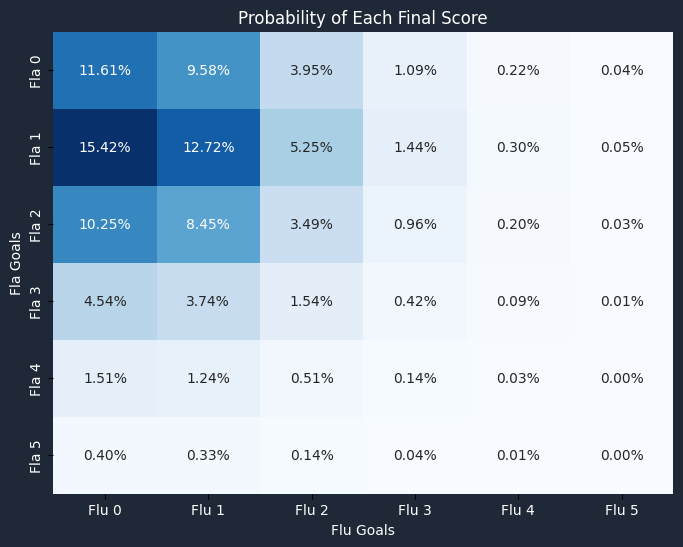

In [32]:
# Matriz de probabilidades
score_matrix = np.outer(PoissonFla, PoissonFlu)

df = pd.DataFrame(score_matrix, index=[f"Fla {i}" for i in goal_range],
                   columns=[f"Flu {i}" for i in goal_range])


# Visualização do heatmap
plt.figure(figsize=(8, 6), facecolor="#1E2836")  # Define o fundo da figura
ax = sns.heatmap(df, annot=True, fmt=".2%", cmap="Blues", cbar=False)
ax.set_facecolor("#1E2836")  # Define o fundo do gráfico
plt.title("Probability of Each Final Score", color="white")  # Ajusta cor do título
plt.xlabel("Flu Goals", color="white")  # Ajusta cor do eixo X
plt.ylabel("Fla Goals", color="white")  # Ajusta cor do eixo Y
plt.xticks(color="white")  # Ajusta cor dos rótulos do eixo X
plt.yticks(color="white")  # Ajusta cor dos rótulos do eixo Y

# Computar probabilidades
Flu_win_prob = np.sum(np.triu(score_matrix, k=1))  # Upper triangle
Fla_win_prob = np.sum(np.tril(score_matrix, k=-1))  # Lower triangle
draw_prob = np.sum(np.diag(score_matrix))  # Diagonal

print(f"Flu Win Probability: {Flu_win_prob:.2%}")
print(f"Fla Win Probability: {Fla_win_prob:.2%}")
print(f"Draw Probability: {draw_prob:.2%}")

plt.show()


### Interpretação das Probabilidades no Heatmap


*   **Probabilidade de Vitória do Fluminense: 23.20%**
*   **Probabilidade de Vitória do Flamengo: 48.26%**
*   **Probabilidade de Empate: 28.27%**

Resultado parecido com as odds do Google para a partida:

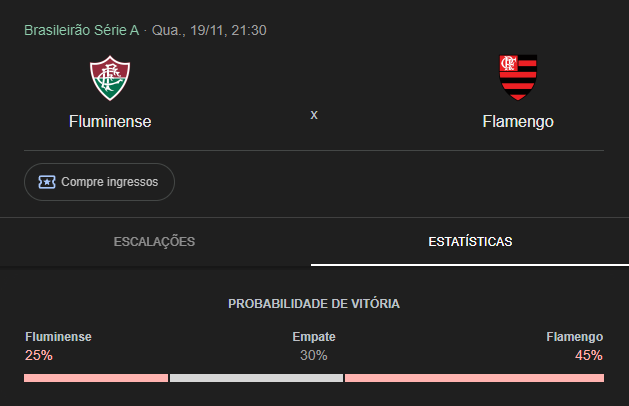